In [5]:
import os 
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
sc.set_figure_params(dpi=80, frameon=False)
sc.logging.print_header()
os.getcwd()

scanpy==1.8.0.dev78+gc488909a anndata==0.7.6 umap==0.5.1 numpy==1.19.2 scipy==1.6.2 pandas==1.2.4 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0


'/mnt/home/icb/leon.hetzel/git/CPA_graphs/notebooks'

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
adata = sc.read('../datasets/lincs.h5ad')
sciplex = sc.read('../datasets/sciplex3_old_reproduced.h5ad')

## Load model

In [8]:
import torch
from compert.train import prepare_compert

state, args, history = torch.load(
    '../pretrained_models/sweep_lincs_logsigm_model_seed=61_epoch=180.pt',
    map_location=torch.device('cpu'))



In [9]:
"../" + args["dataset_path"]

'../datasets/lincs.h5ad'

In [10]:
# args["covariate_keys"] = [args["cell_type_key"]]
# args['smiles_key'] = None
# args['mol_featurizer'] = None
# args['gnn_model'] = None
args["dataset_path"] = "../datasets/lincs.h5ad"

In [11]:
# load the dataset and model pre-trained weights
model, datasets = prepare_compert(args, state_dict=state)

In [12]:
model

ComPert(
  (encoder): MLP(
    (network): Sequential(
      (0): Linear(in_features=978, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=1024, out_features=1024, bias=True)
      (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=1024, out_features=1024, bias=True)
      (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Linear(in_features=1024, out_features=1024, bias=True)
      (10): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): Linear(in_features=1024, out_features=512, bias=True)
    )
  )
  (decoder): MLP(
    (network): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.

In [13]:
model.hparams

{'dim': 512,
 'dosers_width': 128,
 'dosers_depth': 1,
 'dosers_lr': 0.005683993026233652,
 'dosers_wd': 3.1524914838328426e-07,
 'autoencoder_width': 1024,
 'autoencoder_depth': 4,
 'adversary_width': 128,
 'adversary_depth': 3,
 'reg_adversary': 5.53852354347906,
 'penalty_adversary': 6.505923965511245,
 'autoencoder_lr': 0.0008628516090449266,
 'adversary_lr': 0.0007351812167935715,
 'autoencoder_wd': 6.613310426344077e-08,
 'adversary_wd': 0.00045951438224417913,
 'adversary_steps': 3,
 'batch_size': 512,
 'step_size_lr': 45}

## Plot embeddings

In [14]:
from compert.plotting import CompertVisuals
from compert.api import ComPertAPI

In [15]:
%%time
compert_api = ComPertAPI(datasets, model)

CPU times: user 2min 26s, sys: 594 ms, total: 2min 27s
Wall time: 2min 24s


In [16]:
perts_anndata = compert_api.get_drug_embeddings()
perts_anndata.obs['MoA'] = perts_anndata.obs.condition.map(
    dict(zip(list(sciplex.obs.pert_iname.values) + ['DMSO'], list(sciplex.obs.pathway_level_1.values) + ['Vehicle'])))

In [17]:
sc.tl.pca(perts_anndata)
sc.pp.neighbors(perts_anndata, n_neighbors=6, metric='cosine', n_pcs=7)
sc.tl.umap(perts_anndata)

... storing 'MoA' as categorical


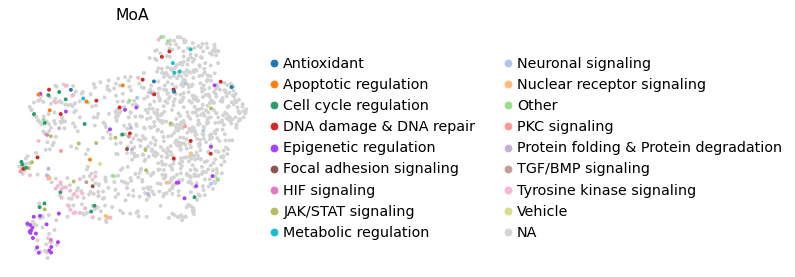

In [18]:
sc.pl.umap(perts_anndata, color='MoA', size=50, groups=set(sciplex.obs.pathway_level_1.unique()))

In [19]:
import numpy as np
MoAs = ['Epigenetic regulation', 'Tyrosine kinase signaling', 'Cell cycle regulation']
cmpds = sciplex[sciplex.obs.pathway_level_1.isin(MoAs)].obs.cond_new.unique()
cmpds = list(np.random.choice(cmpds, size=50, replace=False))
cmpds += ['Dacinostat', 'UNC0379', 'Pracinostat', 'Sirtinol',
    'TMP195', 'GSK', 'PCI-34051', 'Tacedinaline', 'Trametinib',
    'EED226', 'Tucidinostat', 'CUDC-907', 'Selisistat',
    'Anacardic', 'Azacitidine', 'Belinostat',
    'Tazemetostat', 'SRT3025', 'Trichostatin', 'SRT1720', 'Panobinostat', 'UNC0631',
    'A-366', 'Divalproex']
print(cmpds)
cmpds = [dict(zip(sciplex.obs.cond_new, sciplex.obs.pert_iname))[c] for c in set(cmpds) if c != 'Vehicle']

['JQ1', 'JNJ-7706621', 'Abexinostat', 'Danusertib', 'BMS-536924', 'PHA-680632', 'A-366', 'Valproic', 'GSK-LSD1', 'Belinostat', 'PCI-34051', 'Lapatinib', 'CYC116', 'Tubastatin', 'Nintedanib', 'Linifanib', 'Resveratrol', 'Temsirolimus', 'KW-2449', 'Trametinib', 'Tozasertib', 'AG-490', 'TAK-901', 'SRT2104', 'ENMD-2076', 'Sodium', 'BMS-754807', 'Tazemetostat', 'Aurora', 'Ki8751', 'Divalproex', 'Patupilone', 'SRT3025', 'AR-42', 'Sirtinol', 'Epothilone', 'SL-327', 'UNC0379', 'ZM', 'PFI-1', 'GSK1070916', 'Crizotinib', 'Resminostat', 'Sorafenib', 'EED226', 'TGX-221', 'CUDC-101', 'SNS-314', 'Trichostatin', 'Alisertib', 'Dacinostat', 'UNC0379', 'Pracinostat', 'Sirtinol', 'TMP195', 'GSK', 'PCI-34051', 'Tacedinaline', 'Trametinib', 'EED226', 'Tucidinostat', 'CUDC-907', 'Selisistat', 'Anacardic', 'Azacitidine', 'Belinostat', 'Tazemetostat', 'SRT3025', 'Trichostatin', 'SRT1720', 'Panobinostat', 'UNC0631', 'A-366', 'Divalproex']


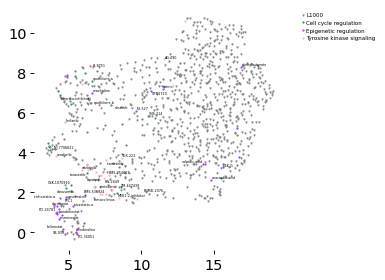

In [20]:
from adjustText import adjust_text

# L1000 dots
pa_subset = perts_anndata[~perts_anndata.obs.MoA.isin(list(set(sciplex.obs.pathway_level_1.unique())))]
x = pa_subset.obsm['X_umap'].T[0]
y = pa_subset.obsm['X_umap'].T[1]
plt.scatter(x, y, label='L1000', color='grey', s=1, marker='v')

# plot colored dots
pa_subset = perts_anndata[perts_anndata.obs.MoA.isin(list(set(sciplex.obs.pathway_level_1.unique())))]
for i, moa in enumerate(pa_subset.obs.MoA.cat.categories):
    subset = pa_subset[pa_subset.obs.MoA == moa].copy()
    x = subset.obsm['X_umap'].T[0]
    y = subset.obsm['X_umap'].T[1]
    if moa in MoAs:
        plt.scatter(x, y, label=moa, color=pa_subset.uns['MoA_colors'][i], s=1, marker='o')
    else:
        plt.scatter(x, y, label='', color='grey', s=1, marker='o')

# plot texts
x = perts_anndata.obsm['X_umap'].T[0]
y = perts_anndata.obsm['X_umap'].T[1]
texts = [plt.text(x[i], y[i], f'{perts_anndata.obs.condition.values[i]}', size=3) for i in range(len(x)) if perts_anndata.obs.condition.values[i] in cmpds]
adjust_text(texts)
plt.grid(b=None)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=5, frameon=False)
# plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')
plt.box(False)
plt.show();

Cell line embedding.

In [17]:
# compert_plots = CompertVisuals(compert_api, fileprefix=None)

In [18]:
covars_anndata = compert_api.get_covars_embeddings()
# covars_anndata.obs['MoA'] = covars_anndata.obs.condition.map(
#     dict(zip(list(sciplex.obs.pert_iname.values) + ['DMSO'], list(sciplex.obs.pathway_level_1.values) + ['Vehicle'])))

In [19]:
sc.tl.pca(covars_anndata)
sc.pp.neighbors(covars_anndata, n_neighbors=6, metric='cosine', n_pcs=7)
sc.tl.umap(covars_anndata)

No handles with labels found to put in legend.


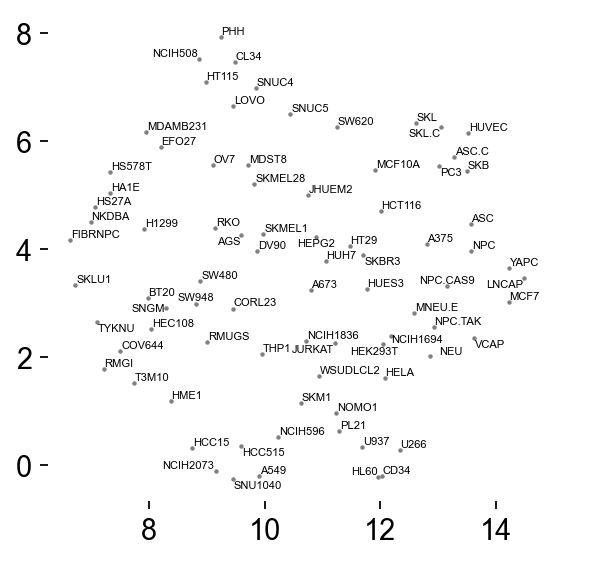

In [20]:
# plot texts
x = covars_anndata.obsm['X_umap'].T[0]
y = covars_anndata.obsm['X_umap'].T[1]
plt.scatter(x, y, label='', color='grey', s=1, marker='o')
texts = [plt.text(x[i], y[i], f'{covars_anndata.obs.cell_type.values[i]}', size=5) for i in range(len(x))]
adjust_text(texts)
plt.grid(b=None)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=5, frameon=False)
# plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')
plt.box(False)
plt.show();

In [81]:
# compert_plots.plot_latent_embeddings(
#     compert_api.emb_covars, kind='covariates', #labels=compert_api.unique_сovars,
#     titlename='cell line embeddings', show_text=False)